In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('data/wine_transformed.csv', sep=",")
data.head()

,country,designation,points,price,province,region_1,region_2,variety,winery
0,1,0,87,35.3634,1,1,1,1,1
1,2,1,87,15.0000,2,2,1,2,2
2,3,2,87,14.0000,3,3,2,3,3
3,3,3,87,13.0000,4,4,1,4,4
4,3,4,87,65.0000,3,3,2,5,5


## Data normalization

In [4]:
normalized_data = np.round((data - np.mean(data)) / np.std(data), 5)
normalized_data.points = data.points
normalized_data.sample(5)

,country,designation,points,price,province,region_1,region_2,variety,winery
62312,-0.35322,-0.76791,94,0.74884,-0.53210,-0.66289,-0.51203,-0.49922,2.22404
111862,0.85020,-0.79858,86,-0.64086,-0.45775,-0.68990,-0.51203,-0.45422,0.57546
114143,0.24849,2.43954,85,-0.51453,-0.06118,1.47653,-0.51203,-0.04929,-0.63611
49956,-0.35322,-0.79858,93,-0.08498,-0.53210,1.39550,-0.51203,0.07069,-0.46926
73433,-0.35322,-0.79858,86,-0.59033,-0.53210,0.21773,-0.51203,-0.46922,-0.93766


## Dimension reduction/Feature Selection

We observed in previous work that our data has very similar values. We can deal with that by applying dimension reduction to the dataset. This also decreases training time without significant loss in accuracy.

### Apply PCA

In [19]:
pca = PCA(n_components=6)
reduced_data = pd.DataFrame(pca.fit_transform(normalized_data.loc[:, normalized_data.columns != "points"]))

In [20]:
reduced_data["points"] = normalized_data.points
reduced_data.head()

,0,1,2,3,4,5,points
0,-1.352087,-0.958920,0.247029,0.642651,0.302715,-1.054143,87
1,-1.115604,-1.138431,-0.139064,0.446499,0.258602,-1.153904,87
2,-1.038342,-1.283100,-0.236290,0.371106,0.151458,-0.843155,87
3,-0.901394,-1.243515,-0.173843,0.433160,0.254711,-1.078389,87
4,-1.146433,-1.081210,0.746329,0.864922,0.271201,-0.379655,87


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2264cf828>,
      dtype=object)

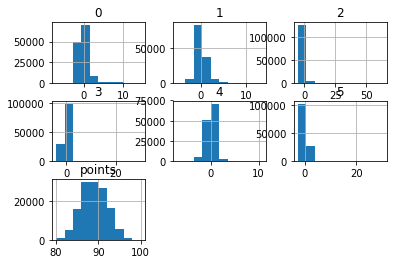

In [21]:
%matplotlib inline
reduced_data.hist()

#### Test

In [22]:
X = reduced_data.loc[:, reduced_data.columns != "points"]
y = reduced_data.points

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print("Train accuracy:", lr.score(x_train, y_train))
print("Test accuracy:",  lr.score(x_test, y_test))

Train accuracy: 0.17833867827065897
Test accuracy: 0.17048822027870178


### Apply Decision Trees

In [25]:
X = normalized_data.loc[:, normalized_data.columns != "points"]
y = normalized_data.points

In [26]:
clf = ExtraTreesClassifier(n_estimators=50)
clf.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
print("Feature importance")
dict(zip(data.columns[data.columns != "points"], clf.feature_importances_  ))

Feature importance


{'country': 0.0245844224613494,
 'designation': 0.1792843588799929,
 'price': 0.27544528893635056,
 'province': 0.050227044076321316,
 'region_1': 0.08956882141476978,
 'region_2': 0.011283062000776566,
 'variety': 0.14041124288091042,
 'winery': 0.22919575934952902}

In [28]:
model = SelectFromModel(clf, prefit=True)
tree_reduced_data = pd.DataFrame(model.transform(X))
tree_reduced_data["points"] = data.points
tree_reduced_data.head()

,0,1,2,3,points
0,-0.79876,0.00000,-0.61920,-1.16931,87
1,-0.79867,-0.51453,-0.60420,-1.16905,87
2,-0.79858,-0.53979,-0.58920,-1.16880,87
3,-0.79848,-0.56506,-0.57420,-1.16854,87
4,-0.79839,0.74884,-0.55921,-1.16829,87


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2260134e0>,
      dtype=object)

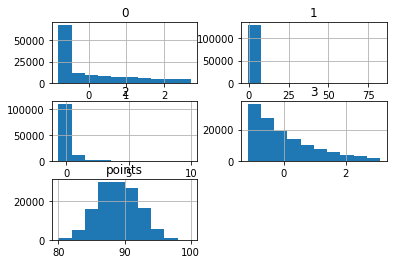

In [29]:
%matplotlib inline
tree_reduced_data.hist()

#### Test

In [30]:
X = tree_reduced_data.loc[:, tree_reduced_data.columns != "points"]
y = tree_reduced_data.points

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print("Train accuracy:", lr.score(x_train, y_train))
print("Test accuracy:",  lr.score(x_test, y_test))

Train accuracy: 0.17845664333153388
Test accuracy: 0.16936618600215347


## Model Selection

In [39]:
X = reduced_data.loc[:, reduced_data.columns != "points"]
y = reduced_data.points

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
svm = SVC().fit(x_train, y_train)
print("Train accuracy:", svm.score(x_train, y_train))
print("Test accuracy:",  svm.score(x_test, y_test))

/home/vosar/anaconda3/envs/ai_hw3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train accuracy: 0.17714664922674464
Test accuracy: 0.16937872667820736


In [49]:
lr = LogisticRegression(C=100, intercept_scaling=50, random_state=42).fit(x_train, y_train)
print("Train accuracy:", lr.score(x_train, y_train))
print("Test accuracy:",  lr.score(x_test, y_test))

/home/vosar/anaconda3/envs/ai_hw3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vosar/anaconda3/envs/ai_hw3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train accuracy: 0.15665153496960837
Test accuracy: 0.1554914406616657
